![StatModels](https://www.durhamtech.edu/themes/custom/durhamtech/images/durham-tech-logo-web.svg) 

## Applications - Statistical Modeling: Data Cleaning

This lecture provides a basic overview on how to clean datasets by using stock price data and additional datsets from the web to ultimately be able to build a machine learning model.

---

# Table of Contents

### Jupyter Overview
#### <a href='#1'>Introduction</a>
* What are you looking for in Data Cleaning?
* Machine learning model building steps

#### <a href='#2'>Data Sources</a>
#### <a href='#3'>Ticker Information</a>
* Datahub
* Wikipedia

#### <a href='#4'>Finance API Functions</a>
#### <a href='#5'>Clean Full S&P 500 Dataset</a>
#### <a href='#6'>Additional Data</a>
* Weather
* FRED
* Series Creation

#### <a href='#7'>Data Overview</a>
#### <a href='#8'>Data Charts</a>
#### <a href='#9'>Saving the Data</a>
#### <a href='#55'>Weekly Readings/Videos</a>
#### <a href='#56'>Extra Practice</a>

<a id='1'></a>
## Introduction

Data cleaning is the process of ensuring data is correct, consistent and usable. You can clean data by identifying errors or corruptions, correcting or deleting them, or manually processing data as needed to prevent the same errors from occurring.
 
Most aspects of data cleaning can be done through the use of software tools, but a portion of it must be done manually. Although this can make data cleaning an overwhelming task, it is an essential part of managing company data.

source: https://www.geotab.com/blog/data-cleaning/

**Our task is to train a machine learning model in order to predict if buying the S&P500 or a single stock today will result in a profit one year from now.**

### What are you looking for in Data Cleaning?

1. Validity (do the values make sense?)
2. Accuracy (how true)
3. Completeness (how much of what we need to know is contained in our dataset?)
4. Consistency (ie: you dont have 10 as a color)
5. Uniformity (ie: same date format across all inputting datasets)

### Machine learning model building steps

1. Identify Your Hypothesis/Question
    - Why are you doing this analysis in the first place?
    - What metric(s) will indicate success for the project?
2. Gather Your Data
    - What is available?
    - How much will it cost?
    - What methods will you need to use to extract it?
3. Clean Your Data
    - Get rid of/Impute null values
    - Remove faulty data
    - Apply bins or groupings
    - Remove duplicates
4. Understand Your Data
    - Graphs
    - Summary statistics
    - Descriptive analytics
    - Verify accuracy
5. Build Several Models
    - Split into training and testing data
    - Use several different types of analysis
6. Test the Models via Iteration
    - Accuracy scores
    - Confusion matrices
    - Other validation metrics

...unfortunately most of the actual work in Data Science often ends up being the part where you clean the data.

![FunnyML](https://pbs.twimg.com/media/Eb63HKNXYAAS-ik.jpg) 

<a id='2'></a>
## Data Sources

1. SP 500 Components: https://datahub.io/core/s-and-p-500-companies
2. SP 500 Company Info: https://en.wikipedia.org/wiki/List_of_S%26P_500_companies
3. TD Ameritrade Data Dicitionary https://developer.tdameritrade.com/content/streaming-data#_Toc504640567
4. Yahoo Finance: https://finance.yahoo.com/quote/%5EGSPC?p=%5EGSPC
5. Weather: https://www.weather.gov/wrh/climate?wfo=okx
6. FRED https://fred.stlouisfed.org/docs/api/fred/series.html

In [1]:
# https://pypi.org/project/yahoo-finance-api2/
# https://github.com/pkout/yahoo_finance_api2

# Uncomment below if you don't have yahoo finance api installed
# pip install yahoo_finance_api2

In [2]:
import requests
import pandas as pd
from pandas.io.json import json_normalize
import time
import math
from yahoo_finance_api2 import share
from yahoo_finance_api2.exceptions import YahooFinanceError
import warnings
import matplotlib.pyplot as plt
import numpy as np
import json
import datetime

warnings.filterwarnings('ignore')
key = 'RGOLSJPSTGVAN4NTN4DLWJE71SU7SIH0'

In [3]:
# view file contents
%ls

DFF.csv                 confusion.png           sp_500_wiki.png
Data_Cleaning.ipynb     constituents_csv.csv    test_train.png
GDPC1.csv               logreg.png              validation.png
Machine_Learning.ipynb  nyc_precip.xlsx         yahoo_data.csv
Regression.ipynb        nyc_temp.xlsx           yahoo_data2.xlsx
SP500_info.csv          precision.png
UNRATE.csv              recall.png


<a id='3'></a>
## Ticker Information

Let's look at the S&P 500

![image.png](sp_500_wiki.png)

In [4]:
# S&P500 Components
# Sometimes we can simply just download data via web clicks.

tickers=pd.read_csv("constituents_csv.csv")
print(len(tickers)) # Does 505 tickers make sense?
tickers.head()

505


,Symbol,Name,Sector
0,MMM,3M,Industrials
1,AOS,A. O. Smith,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie,Health Care
4,ABMD,Abiomed,Health Care


In [5]:
# Wikipedia Summary of S&P500
# Sometimes we have to use copy and paste.  For larger/more intricate pulls we can use webscraping.

ticker_info=pd.read_csv("sp500_info.csv")
print(len(ticker_info))
ticker_info.head()

505


,Symbol,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",8/9/76,66740,1902
1,ABT,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",3/31/64,1800,1888
2,ABBV,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",12/31/12,1551152,2013 (1888)
3,ABMD,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",5/31/18,815094,1981
4,ACN,Accenture,reports,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",7/6/11,1467373,1989


In [6]:
# Merge the two datasets to verify information -> it looks good

tickers=pd.merge(tickers,ticker_info,on='Symbol',how='inner')
print(len(tickers))
tickers.head()

505


,Symbol,Name,Sector,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
0,MMM,3M,Industrials,3M,reports,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",8/9/76,66740,1902
1,AOS,A. O. Smith,Industrials,A. O. Smith,reports,Industrials,Building Products,"Milwaukee, Wisconsin",7/26/17,91142,1916
2,ABT,Abbott Laboratories,Health Care,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",3/31/64,1800,1888
3,ABBV,AbbVie,Health Care,AbbVie,reports,Health Care,Pharmaceuticals,"North Chicago, Illinois",12/31/12,1551152,2013 (1888)
4,ABMD,Abiomed,Health Care,Abiomed,reports,Health Care,Health Care Equipment,"Danvers, Massachusetts",5/31/18,815094,1981


In [7]:
# Save space and improve runtime by deleting the dataframe from memory
del ticker_info

<a id='4'></a>
## Finance API Functions

In [8]:
def get_td_price_hist(ticker,period,key,row_count='Blank'):
    time.sleep(1)
    endpoint = 'https://api.tdameritrade.com/v1/marketdata/'+ticker+'/pricehistory'

    ##Define Payload
    payload = {'apikey': key,
    'periodType': 'year',
    'period':period,
    'frequencyType':'daily'}

    ### make request
    try:
        content = requests.get(url = endpoint, params = payload)
    except:
        print('API error, please review.')
        
    ### Convert to dictionary
    dictlist = []
    data = content.json()

    for key, value in data.items():
        temp = [key,value]
        dictlist.append(temp)
        
    try:
        hist_data = pd.DataFrame(dictlist[0][1])
        hist_data['datetime'] = pd.to_datetime(hist_data['datetime'],unit='ms')
        hist_data.sort_values(by=['datetime'],ascending=False)
        hist_data=hist_data.sort_values(by=['datetime'],ascending=True).reset_index()
        hist_data['Date']=hist_data['datetime'].dt.date
        hist_data=hist_data.drop(['index','datetime'],axis=1)
        hist_data['ticker'] = ticker
        if row_count!='Blank':
            return hist_data.tail(row_count)
        else:
            return hist_data
    except:
        df = pd.DataFrame()
        print('running except clause')
        return df
    
def get_fundamental_from_td(ticker,key):
    time.sleep(1)
    endpoint = 'https://api.tdameritrade.com/v1/instruments'
    projection = 'fundamental'

    ##Define Payload
    payload = {'apikey': key,
               'symbol' : ticker,
                'projection': projection,
                }
    
    ### make request
    try:
        content = requests.get(url = endpoint, params = payload)
    except:
        print('API error, please review.')
        
    ### Convert to dictionary
    dictlist = []
    data = content.json()
    for key, value in data.items():
        temp = [key,value]
        dictlist.append(temp)
        
    try:
        df = pd.DataFrame(dictlist[0][1]).T.reset_index(drop=True).iloc[0]
        return df
    except:
        print(dictlist)
        df = pd.DataFrame()
        print(ticker + " not valid.")
        return df
    
def get_yahoo_history(share_name):
    print("Pulling history")

    if share_name[-1]=='2':
        my_share = share.Share(share_name[:-1])
    else:
        my_share = share.Share(share_name)
    symbol_data = None

    try:
        symbol_data = my_share.get_historical(share.PERIOD_TYPE_YEAR,
                                              30000,
                                              share.FREQUENCY_TYPE_DAY,
                                              1)
        df = pd.DataFrame(symbol_data)
        df['timestamp'] = df['timestamp'].astype(str)
        df['timestamp'] = df['timestamp'].map(lambda x: x[:-3])
        df['Date'] =df['timestamp'].astype('int')
        df['Date'] = pd.to_datetime(df['Date'],unit='s')
        df=df.sort_values(by=['Date'],ascending=True)
        df['Date']=df['Date'].dt.date
        df=df.drop(['timestamp'],axis=1)
        df['ticker']=str(share_name.upper())
    except YahooFinanceError as e:
        print(e.message)
        sys.exit(1)
    return df

In [9]:
# View a certain ticker's information
ticker=tickers['Symbol'][2]
tickers.iloc[[2]]

,Symbol,Name,Sector,Security,SEC filings,GICS Sector,GICS Sub-Industry,Headquarters Location,Date first added,CIK,Founded
2,ABT,Abbott Laboratories,Health Care,Abbott Laboratories,reports,Health Care,Health Care Equipment,"North Chicago, Illinois",3/31/64,1800,1888


In [10]:
# Fundamental data from TD Ameritrade from that ticker... does this help our analysis?
pd.DataFrame(get_fundamental_from_td(ticker,key)).T

,beta,bookValuePerShare,currentRatio,divGrowthRate3Year,dividendAmount,dividendDate,dividendPayAmount,dividendPayDate,dividendYield,epsChange,...,revChangeYear,sharesOutstanding,shortIntDayToCover,shortIntToFloat,symbol,totalDebtToCapital,totalDebtToEquity,vol10DayAvg,vol1DayAvg,vol3MonthAvg
0,0.68469,5.14435,1.82576,0,1.8,2021-10-14 00:00:00.000,0.45,2021-11-15 00:00:00.000,1.43,0,...,0,1.76829e+09,0,0,ABT,34.6884,53.4455,4.87444e+06,4.87444e+06,1.05216e+08


In [11]:
# We are going to get historical price data from TD Ameritrade even though it looks like it doesn't go as 
# far back as Yahoo Finance API's.  This is just to verify that Yahoo has relatively correct data.

print(ticker)
#td_data=get_td_price_hist(ticker,1,key,43)
td_data=get_td_price_hist(ticker,1,key)
print(len(td_data))
td_data.tail()

ABT
252


,open,high,low,close,volume,Date,ticker
247,128.410,128.5300,126.46,126.84,6867681,2021-11-19,ABT
248,126.780,126.8000,124.68,125.26,4205655,2021-11-22,ABT
249,124.510,124.8900,123.22,124.48,4873730,2021-11-23,ABT
250,124.065,125.2818,124.00,125.07,3729581,2021-11-24,ABT
251,127.810,129.7500,125.44,125.88,4671350,2021-11-26,ABT


In [12]:
# Yahoo Finance API's data for our ticker.  
# Notice the difference in the number of rows compared to TD Ameritrade.

yahoo_data=get_yahoo_history(ticker)
print(len(yahoo_data))
yahoo_data.head()

Pulling history
10516


,open,high,low,close,volume,Date,ticker
0,0.0,0.512028,0.497999,0.501506,7513463,1980-03-17,ABT
1,0.0,0.512028,0.494492,0.505013,5303621,1980-03-18,ABT
2,0.0,0.515535,0.503260,0.512028,2523497,1980-03-19,ABT
3,0.0,0.513781,0.499753,0.499753,4654925,1980-03-20,ABT
4,0.0,0.506767,0.499753,0.505013,1333034,1980-03-21,ABT


In [13]:
# Let's merge the two datasets together and view the summary statistics for the top 10 rows for each.
# This can give us a basic idea if there are any glaring errors.

#pd.merge(yahoo_data,td_data,on=['Date'],how='outer',indicator=True)
pd.merge(yahoo_data.tail(10),td_data.tail(10),on=['Date'],how='outer',indicator=True).describe()

,open_x,high_x,low_x,close_x,volume_x,open_y,high_y,low_y,close_y,volume_y
count,10.000000,10.000000,10.000000,10.000000,1.000000e+01,10.00000,10.000000,10.000000,10.000000,1.000000e+01
mean,127.785001,128.603000,126.482999,127.256999,4.872370e+06,127.78450,128.603180,126.483000,127.257000,4.874437e+06
std,2.125759,2.262624,2.105209,2.106724,1.001654e+06,2.12673,2.262675,2.105211,2.106725,1.005818e+06
min,124.070000,124.889999,123.220001,124.480003,3.729500e+06,124.06500,124.890000,123.220000,124.480000,3.729581e+06
25%,127.037498,127.232502,124.870001,125.415001,4.270575e+06,127.03750,127.232500,124.870000,125.415000,4.270992e+06
50%,128.175003,129.139999,126.790001,127.239998,4.618600e+06,128.17500,129.140000,126.790000,127.240000,4.618646e+06
75%,129.174999,130.087498,128.062496,128.577496,4.845250e+06,129.17500,130.083750,128.062500,128.577500,4.845270e+06
max,130.610001,131.600006,129.639999,130.889999,6.848400e+06,130.61000,131.605000,129.640000,130.890000,6.867681e+06


<a id='5'></a>
## Clean Full S&P 500 Dataset

In [14]:
# S&P 500's ticker on yahoo finance
ticker='^GSPC'

# Pull the data
yahoo_data=get_yahoo_history(ticker)
print(len(yahoo_data))

#This goes back all the way to 1962... great!
yahoo_data

Pulling history
14841


,open,high,low,close,volume,Date,ticker
0,0.000000,63.070000,62.090000,62.419998,3380000,1962-12-13,^GSPC
1,0.000000,62.830002,61.959999,62.570000,3280000,1962-12-14,^GSPC
2,0.000000,62.950001,62.139999,62.369999,3590000,1962-12-17,^GSPC
3,0.000000,62.660000,61.779999,62.070000,3620000,1962-12-18,^GSPC
4,0.000000,62.810001,61.720001,62.580002,4000000,1962-12-19,^GSPC
...,...,...,...,...,...,...,...
14836,4708.439941,4717.750000,4694.220215,4697.959961,3265600000,2021-11-19,^GSPC
14837,4712.000000,4743.830078,4682.169922,4682.939941,3206280000,2021-11-22,^GSPC
14838,4678.479980,4699.390137,4652.660156,4690.700195,3428780000,2021-11-23,^GSPC
14839,4675.779785,4702.870117,4659.890137,4701.459961,2464040000,2021-11-24,^GSPC


<a id='6'></a>
## Additional Data

![FunnyML3](https://memegenerator.net/img/instances/41658979/i-just-dont-know-theres-not-enough-data.jpg)

### Weather

In [15]:
# The user interface is fairly difficult to use and requires a bit of processing before we load in.
temp=pd.read_excel('nyc_temp.xlsx')
prec=pd.read_excel('nyc_precip.xlsx')
temp

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
0,1960,33.9,36.3,33.4,54.0,62.6,71.8,74.5,74.9,68.0,58.0,49.7,30.9
1,1961,27.7,36.6,41.5,49.0,59.8,72.4,78.1,76.4,73.5,61.1,48.7,35.5
2,1962,32.6,31.8,43.0,53.3,64.4,72.5,74.0,72.4,64.9,57.4,43.2,31.5
3,1963,30.1,28.2,43.7,53.7,61.1,70.9,76.4,72.1,63.1,61.8,50.3,31.2
4,1964,35.6,32.8,43.1,49.7,65.4,71.6,75.4,72.9,67.1,55.0,49.4,36.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2017,38.0,41.6,39.2,57.2,61.1,72.0,76.8,74.0,70.5,64.1,46.6,35
58,2018,31.7,42.0,40.1,49.5,66.9,71.7,77.6,78.1,70.7,57.7,44.4,40.1
59,2019,32.5,36.2,41.7,55.5,62.2,71.7,79.6,75.5,70.4,59.9,43.9,38.3
60,2020,39.1,40.1,48.0,50.4,60.3,73.7,80.0,76.9,68.8,57.9,53.0,39.2


In [16]:
# Change how the table is shaped so we can merge to our ticker data

prec=prec.replace('', np.nan).set_index('Year').stack().reset_index(name='prec').rename(columns={"level_1": "Month"})
temp=temp.replace('', np.nan).set_index('Year').stack().reset_index(name='temp').rename(columns={"level_1": "Month"})
temp

,Year,Month,temp
0,1960,Jan,33.9
1,1960,Feb,36.3
2,1960,Mar,33.4
3,1960,Apr,54
4,1960,May,62.6
...,...,...,...
739,2021,Aug,77.5
740,2021,Sep,70.3
741,2021,Oct,62
742,2021,Nov,47.9


![FunnyML2](https://preview.redd.it/hphalpxaap181.jpg?width=640&crop=smart&auto=webp&s=3ad9a6178fad8e55eddb61bce9f472cce51980a0)

In [17]:
# https://stackoverflow.com/questions/42684530/convert-a-column-in-a-python-pandas-from-string-month-into-int
from calendar import month_abbr

lower_ma = [m.lower() for m in month_abbr]

prec['Month']=prec['Month'].str.lower().map(lambda m: lower_ma.index(m)).astype('Int8')
temp['Month']=temp['Month'].str.lower().map(lambda m: lower_ma.index(m)).astype('Int8')

# Merge the weather data with our stock data
yahoo_data['month']=pd.to_datetime(yahoo_data.Date).dt.month
yahoo_data['year']=pd.to_datetime(yahoo_data.Date).dt.year
yahoo_data['quarter']=pd.to_datetime(yahoo_data.Date).dt.quarter
yahoo_data=pd.merge(yahoo_data,prec,left_on=['month','year'],right_on=['Month','Year'],how='left')
yahoo_data=yahoo_data.drop(['Month','Year'],axis=1)
yahoo_data=pd.merge(yahoo_data,temp,left_on=['month','year'],right_on=['Month','Year'],how='left')
yahoo_data=yahoo_data.drop(['Month','Year'],axis=1)
yahoo_data

,open,high,low,close,volume,Date,ticker,month,year,quarter,prec,temp
0,0.000000,63.070000,62.090000,62.419998,3380000,1962-12-13,^GSPC,12,1962,4,2.26,31.5
1,0.000000,62.830002,61.959999,62.570000,3280000,1962-12-14,^GSPC,12,1962,4,2.26,31.5
2,0.000000,62.950001,62.139999,62.369999,3590000,1962-12-17,^GSPC,12,1962,4,2.26,31.5
3,0.000000,62.660000,61.779999,62.070000,3620000,1962-12-18,^GSPC,12,1962,4,2.26,31.5
4,0.000000,62.810001,61.720001,62.580002,4000000,1962-12-19,^GSPC,12,1962,4,2.26,31.5
...,...,...,...,...,...,...,...,...,...,...,...,...
14836,4708.439941,4717.750000,4694.220215,4697.959961,3265600000,2021-11-19,^GSPC,11,2021,4,M,47.9
14837,4712.000000,4743.830078,4682.169922,4682.939941,3206280000,2021-11-22,^GSPC,11,2021,4,M,47.9
14838,4678.479980,4699.390137,4652.660156,4690.700195,3428780000,2021-11-23,^GSPC,11,2021,4,M,47.9
14839,4675.779785,4702.870117,4659.890137,4701.459961,2464040000,2021-11-24,^GSPC,11,2021,4,M,47.9


In [18]:
# Missing data - we will not get rid of it (reason is explained later)
yahoo_data[(yahoo_data['prec']=='M')|(yahoo_data['temp']=='M')]

,open,high,low,close,volume,Date,ticker,month,year,quarter,prec,temp
14822,4610.620117,4620.339844,4595.060059,4613.669922,2924000000,2021-11-01,^GSPC,11,2021,4,M,47.9
14823,4613.339844,4635.149902,4613.339844,4630.649902,3309690000,2021-11-02,^GSPC,11,2021,4,M,47.9
14824,4630.649902,4663.459961,4621.189941,4660.569824,3339440000,2021-11-03,^GSPC,11,2021,4,M,47.9
14825,4662.930176,4683.000000,4662.589844,4680.060059,3332940000,2021-11-04,^GSPC,11,2021,4,M,47.9
14826,4699.259766,4718.500000,4681.319824,4697.529785,3491150000,2021-11-05,^GSPC,11,2021,4,M,47.9
14827,4701.479980,4714.919922,4694.390137,4701.700195,3465720000,2021-11-08,^GSPC,11,2021,4,M,47.9
14828,4707.250000,4708.529785,4670.870117,4685.250000,3110230000,2021-11-09,^GSPC,11,2021,4,M,47.9
14829,4670.259766,4684.850098,4630.859863,4646.709961,3581630000,2021-11-10,^GSPC,11,2021,4,M,47.9
14830,4659.390137,4664.549805,4648.310059,4649.270020,2623140000,2021-11-11,^GSPC,11,2021,4,M,47.9
14831,4655.240234,4688.470215,4650.770020,4682.850098,2865790000,2021-11-12,^GSPC,11,2021,4,M,47.9


### FRED

In [19]:
# Federal funds effective rate data
dff=pd.read_csv('DFF.csv')

# Unemployment rate data
unrate=pd.read_csv('UNRATE.csv')
unrate['month']=pd.to_datetime(unrate.DATE).dt.month
unrate['year']=pd.to_datetime(unrate.DATE).dt.year
unrate.drop('DATE',axis=1,inplace=True)

# GDP Data - we may not use it though
gdp=pd.read_csv('GDPC1.csv')
gdp['quarter']=pd.to_datetime(gdp.DATE).dt.quarter
gdp['year']=pd.to_datetime(gdp.DATE).dt.year
gdp.drop('DATE',axis=1,inplace=True)

yahoo_data=pd.merge(yahoo_data,dff,left_on=pd.to_datetime(yahoo_data.Date),right_on=pd.to_datetime(dff.DATE),how='inner')
yahoo_data=pd.merge(yahoo_data,unrate,on=['month','year'],how='inner')
yahoo_data.drop(['key_0','DATE'],axis=1,inplace=True)
yahoo_data=pd.merge(yahoo_data,gdp,on=['quarter','year'],how='inner')
yahoo_data

,open,high,low,close,volume,Date,ticker,month,year,quarter,prec,temp,DFF,UNRATE,GDPC1
0,0.000000,63.070000,62.090000,62.419998,3380000,1962-12-13,^GSPC,12,1962,4,2.26,31.5,2.88,5.5,3589.128
1,0.000000,62.830002,61.959999,62.570000,3280000,1962-12-14,^GSPC,12,1962,4,2.26,31.5,3.00,5.5,3589.128
2,0.000000,62.950001,62.139999,62.369999,3590000,1962-12-17,^GSPC,12,1962,4,2.26,31.5,3.00,5.5,3589.128
3,0.000000,62.660000,61.779999,62.070000,3620000,1962-12-18,^GSPC,12,1962,4,2.26,31.5,3.00,5.5,3589.128
4,0.000000,62.810001,61.720001,62.580002,4000000,1962-12-19,^GSPC,12,1962,4,2.26,31.5,3.00,5.5,3589.128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14796,4438.040039,4463.120117,4430.270020,4455.479980,2772090000,2021-09-24,^GSPC,9,2021,3,10.03,70.3,0.08,4.8,19469.398
14797,4442.120117,4457.299805,4436.189941,4443.109863,3032870000,2021-09-27,^GSPC,9,2021,3,10.03,70.3,0.08,4.8,19469.398
14798,4419.540039,4419.540039,4346.330078,4352.629883,3495970000,2021-09-28,^GSPC,9,2021,3,10.03,70.3,0.08,4.8,19469.398
14799,4362.410156,4385.569824,4355.080078,4359.459961,2753800000,2021-09-29,^GSPC,9,2021,3,10.03,70.3,0.08,4.8,19469.398


### Series creation

In [20]:
# 1 year
days_out=252

# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.rolling.html
# https://stackoverflow.com/questions/61319814/moving-average-in-pandas-issue-with-first-and-last-rows

yahoo_data['volume_moving'] = yahoo_data['volume'].rolling(days_out).mean().shift(periods=1)
yahoo_data['volume_moving_std']=yahoo_data['volume'].rolling(days_out).std().shift(periods=1)
yahoo_data['close_moving'] = yahoo_data['close'].rolling(days_out).mean().shift(periods=1)
yahoo_data['close_moving_std']=yahoo_data['close'].rolling(days_out).std().shift(periods=1)

# https://stackoverflow.com/questions/42138357/pandas-rolling-slope-calculation

def calc_slope(x):
    slope = np.polyfit(range(len(x)), x, 1)[0]
    return slope

yahoo_data['volume_slope'] = yahoo_data['volume'].rolling(days_out).apply(calc_slope).shift(periods=1)
yahoo_data['close_slope'] = yahoo_data['close'].rolling(days_out).apply(calc_slope).shift(periods=1)

yahoo_data['close_future'] = yahoo_data['close'].shift(periods=-days_out)
yahoo_data.dropna(inplace=True)
yahoo_data

,open,high,low,close,volume,Date,ticker,month,year,quarter,...,DFF,UNRATE,GDPC1,volume_moving,volume_moving_std,close_moving,close_moving_std,volume_slope,close_slope,close_future
252,0.000000,74.660004,73.779999,74.300003,4280000,1963-12-16,^GSPC,12,1963,4,...,3.50,5.5,3774.264,4.524048e+06,9.268485e+05,69.318809,3.225283,4.007497e+03,0.041370,83.220001
253,0.000000,75.080002,74.070000,74.739998,5140000,1963-12-17,^GSPC,12,1963,4,...,3.50,5.5,3774.264,4.527619e+06,9.241526e+05,69.365952,3.210835,3.876007e+03,0.041184,83.550003
254,0.000000,75.209999,74.250000,74.629997,6000000,1963-12-18,^GSPC,12,1963,4,...,3.50,5.5,3774.264,4.535000e+06,9.215726e+05,69.414246,3.199715,3.815290e+03,0.041045,83.900002
255,0.000000,74.919998,74.080002,74.400002,4410000,1963-12-19,^GSPC,12,1963,4,...,3.50,5.5,3774.264,4.544563e+06,9.242278e+05,69.462897,3.185355,3.863518e+03,0.040868,84.290001
256,0.000000,74.750000,73.849998,74.279999,4600000,1963-12-20,^GSPC,12,1963,4,...,3.50,5.5,3774.264,4.547698e+06,9.224173e+05,69.511825,3.165982,3.763152e+03,0.040631,84.379997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14544,3226.139893,3278.699951,3209.449951,3246.590088,4599470000,2020-09-24,^GSPC,9,2020,3,...,0.09,7.8,18560.774,4.650244e+09,1.464733e+09,3092.189362,246.356374,6.489758e+06,0.868322,4455.479980
14545,3236.659912,3306.879883,3228.439941,3298.459961,3792220000,2020-09-25,^GSPC,9,2020,3,...,0.09,7.8,18560.774,4.655326e+09,1.462315e+09,3093.227933,246.453794,6.358687e+06,0.872673,4443.109863
14546,3333.899902,3360.739990,3332.909912,3351.600098,3946060000,2020-09-28,^GSPC,9,2020,3,...,0.09,7.8,18560.774,4.658163e+09,1.459933e+09,3094.501107,246.682806,6.127766e+06,0.881020,4352.629883
14547,3350.919922,3357.919922,3327.540039,3335.469971,3651880000,2020-09-29,^GSPC,9,2020,3,...,0.09,7.8,18560.774,4.660950e+09,1.457891e+09,3096.047973,247.069186,5.926572e+06,0.892627,4359.459961


<a id='7'></a>
## Data Overview

In [21]:
# Does this look like what you would expect?
yahoo_data.describe()

,open,high,low,close,volume,month,year,quarter,DFF,UNRATE,GDPC1,volume_moving,volume_moving_std,close_moving,close_moving_std,volume_slope,close_slope,close_future
count,14297.000000,14297.000000,14297.000000,14297.000000,1.429700e+04,14297.000000,14297.000000,14297.000000,14297.000000,14297.000000,14297.000000,1.429700e+04,1.429700e+04,14297.000000,14297.000000,1.429700e+04,14297.000000,14297.000000
mean,740.875258,776.859604,767.310045,772.401641,1.246897e+09,6.511926,1991.879765,2.503742,5.095054,6.013807,10574.966061,1.203572e+09,2.460995e+08,745.270707,41.796068,3.499478e+05,0.208588,841.608424
std,820.898457,797.474045,788.933199,793.515544,1.725443e+09,3.429258,16.371586,1.113899,3.770244,1.729828,4614.707064,1.631287e+09,3.657124e+08,761.187262,45.341803,2.286587e+06,0.611810,896.077603
min,0.000000,63.230000,60.959999,62.279999,3.020000e+06,1.000000,1963.000000,1.000000,0.040000,3.400000,3774.264000,4.524048e+06,6.985104e+05,69.318809,1.731005,-1.236332e+07,-3.116969,62.279999
25%,0.000000,106.440002,104.580002,105.550003,2.588000e+07,4.000000,1978.000000,2.000000,1.980000,4.800000,6333.848000,2.115028e+07,6.718374e+06,102.661825,5.886803,-1.027606e+04,-0.013726,108.379997
50%,412.859985,414.799988,410.660004,412.880005,2.157400e+08,7.000000,1992.000000,3.000000,5.050000,5.700000,9643.893000,1.883880e+08,4.154112e+07,394.585198,20.550512,2.715262e+04,0.090458,446.179993
75%,1254.660034,1262.609985,1243.989990,1254.780029,2.335000e+09,9.000000,2006.000000,3.000000,6.930000,7.200000,15216.647000,2.223477e+09,3.506189e+08,1229.096667,72.431773,3.775613e+05,0.473743,1285.579956
max,3564.739990,3588.110107,3535.229980,3580.840088,1.145623e+10,12.000000,2020.000000,4.000000,22.360000,14.800000,19202.310000,6.093193e+09,1.607984e+09,3097.471504,247.412238,1.409985e+07,2.018267,4536.950195


In [22]:
# Notice temperature and precipitation are not floats... why is this an issue?
yahoo_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14297 entries, 252 to 14548
Data columns (total 22 columns):
open                 14297 non-null float64
high                 14297 non-null float64
low                  14297 non-null float64
close                14297 non-null float64
volume               14297 non-null int64
Date                 14297 non-null object
ticker               14297 non-null object
month                14297 non-null int64
year                 14297 non-null int64
quarter              14297 non-null int64
prec                 14297 non-null object
temp                 14297 non-null object
DFF                  14297 non-null float64
UNRATE               14297 non-null float64
GDPC1                14297 non-null float64
volume_moving        14297 non-null float64
volume_moving_std    14297 non-null float64
close_moving         14297 non-null float64
close_moving_std     14297 non-null float64
volume_slope         14297 non-null float64
close_slope          

In [23]:
# Change the data type of precipation and temperature
yahoo_data['prec']=yahoo_data['prec'].astype('float')
yahoo_data['temp']=yahoo_data['temp'].astype('float')

<a id='8'></a>
## Data Charts

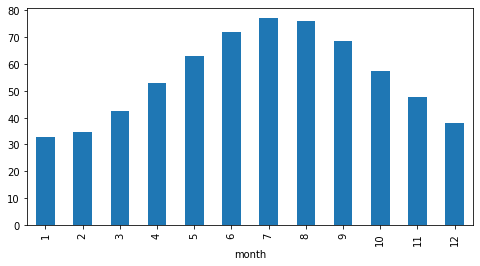

In [24]:
# Average monthly temperature over the years
plt.figure(figsize=(8, 4))
yahoo_data['temp'].groupby(yahoo_data['month']).mean().plot(kind="bar")

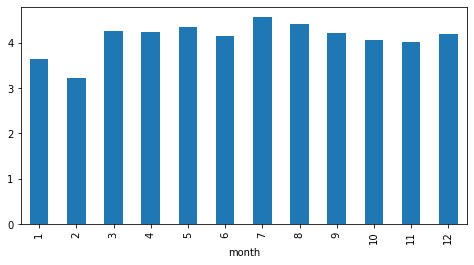

In [25]:
# Average monthly precipation over the year
plt.figure(figsize=(8, 4))
yahoo_data['prec'].groupby(yahoo_data['month']).mean().plot(kind="bar")

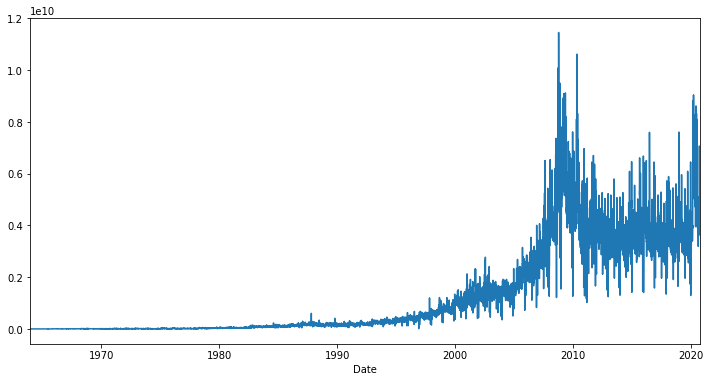

In [26]:
# How much trade volume over time
plt.figure(figsize=(12, 6))
yahoo_data.set_index('Date')['volume'].plot()

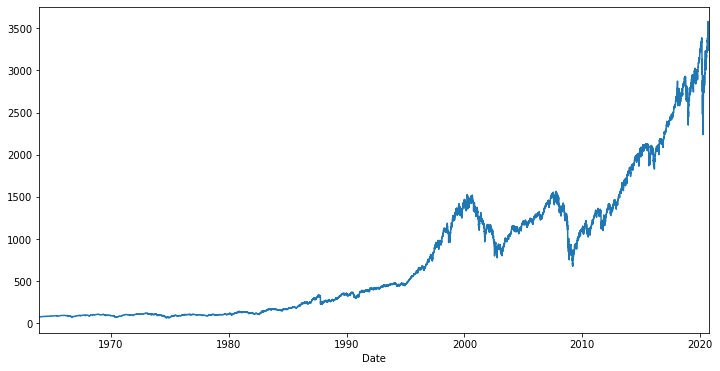

In [27]:
# Closing stock price over time
plt.figure(figsize=(12, 6))
yahoo_data.set_index('Date')['close'].plot()

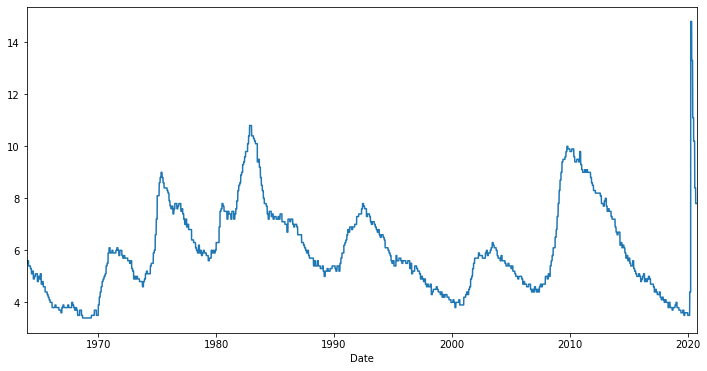

In [28]:
# Unemployment rate over time
plt.figure(figsize=(12, 6))
yahoo_data.set_index('Date')['UNRATE'].plot()

<Figure size 864x432 with 0 Axes>

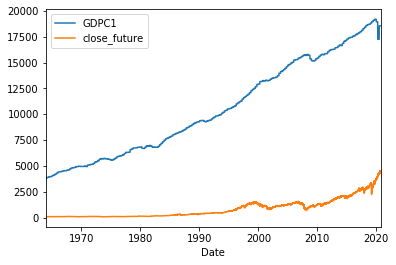

In [29]:
# GDP vs future closing price over time
plt.figure(figsize=(12, 6))
yahoo_data.set_index('Date')[['GDPC1','close_future']].plot()

<Figure size 576x576 with 0 Axes>

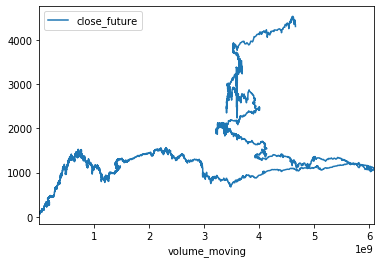

In [30]:
# Line chart of volume moving trends and the future closing price one year from now
plt.figure(figsize=(8, 8))
yahoo_data[['volume_moving','close_future']].plot(kind="line", x='volume_moving', y='close_future')

<Figure size 576x576 with 0 Axes>

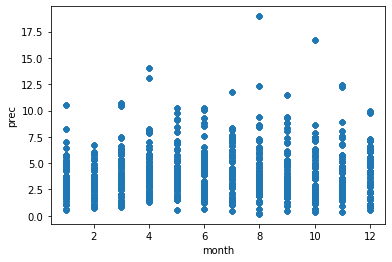

In [31]:
# Scatter plot of precipitation and month
plt.figure(figsize=(8, 8))
yahoo_data[['prec','month']].plot(kind="scatter", x='month', y='prec')

In [32]:
# How many null values exist in our dataframe (per each column)?

NullsPerColumn = []
for col in yahoo_data:
    x=yahoo_data[col].isna().sum()
    y=len(yahoo_data[col])
    NullsPerColumn.append(x/y)
print(NullsPerColumn)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


<a id='9'></a>
## Saving the Data

In [33]:
# Drop unnecessary columns and export the data to a csv file so we can use the data later 
# for our analysis.

yahoo_data.drop(columns=['high','low','volume','ticker','Date','month','quarter','year'],inplace=True)
yahoo_data.to_csv('yahoo_data.csv')
%ls

DFF.csv                 confusion.png           sp_500_wiki.png
Data_Cleaning.ipynb     constituents_csv.csv    test_train.png
GDPC1.csv               logreg.png              validation.png
Machine_Learning.ipynb  nyc_precip.xlsx         yahoo_data.csv
Regression.ipynb        nyc_temp.xlsx           yahoo_data2.xlsx
SP500_info.csv          precision.png
UNRATE.csv              recall.png


<a id='55'></a>
# Weekly Readings/Videos

https://towardsdatascience.com/the-ultimate-guide-to-data-cleaning-3969843991d4

https://medium.com/analytics-vidhya/a-beginners-guide-to-matplotlib-for-data-visualization-and-exploration-in-python-3fb32d03c3cd

<a id='56'></a>
# Extra Practice